## Topic

__Discuss whether a sequence of play advancement (ball moving forward or backward) in a soccer game forms a Markov chain.__

## Level

Senior undergraduate or first-year graduate students.

## Language

Sample code is written in python.

## Learning goal

- Students understand the concept and common application of Markov chain.
- Students learn method(s) to calculate Markov chain matrix.
- Students learn data cleaning and transformation.
- Students learn basic data structure.
- Students learn how to visualize data and interpret the result.

## Sample code and Exercises

In [1]:
from statsbombpy import sb

import requests
import json
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

### 1. Request data from source. 
Here we are pulling data from Statsbombs's open data repository: https://github.com/statsbomb/open-data. The raw data is in json format and needs to be transformed to analyze. 

__*Q: where can we find the term of use for this data and what does it tell us?*__ \
__(Note: pay attention to 1.2 and 2.2. https://github.com/statsbomb/open-data/blob/master/LICENSE.pdf )__

In [3]:
def load_json(url):
    '''
    Load json data from the given URL.
    '''
    response = requests.get(url)
    return response.json()

In [4]:
def get_season(competition_id, season_id):
    url = f'https://raw.githubusercontent.com/statsbomb/open-data/master/data/matches/{competition_id}/{season_id}.json'
    season_js = load_json(url)
    return season_js

If we want to check out the data for FA Women's Super League 2020/2021 season, we can assign the competition_id (37) and season_id (90) to the function get_season above.

In [5]:
WSL_2020 = get_season(37, 90)

<span style="color:brown">_Note: all answers provided are suggested guidance and not expected word for word._<span style="color:brown">

__*Q: what is the data structure of the returned object?*__ \
(A: a list of dictionaries.)

__*Q: What information does this object contains?*__ 

__*Q: how can we get other competition_ids and season_ids?*__ \
(A: 
- use statsbomb api that is provided in the repository. <span style="color:blue">cp = sb.competitions()<span style="color:blue"> .
- load (use load_json function above) or browse online json file directly https://github.com/statsbomb/open-data/blob/master/data/competitions.json .     )


In [6]:
def get_events(match_id):
    url = f'https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/{match_id}.json'
    events_js = load_json(url)
    return events_js

If we want to check out the event-by-event data for the game Aston Villa vs Arsenal WFC on 2021-02-28, we can assign the match_id (3775648) to the function get_events above.

In [7]:
events_3775648 = get_events(3775648)

__*Q: besides event-by-event data, what other types of data can we find from the repository?*__ \
(A: line-ups data and three-sixty freeze frame data)

__*Q: what are other ways to load the events information?*__ \
(A: 
- use statsbomb api. <span style="color:blue">event_3775648_api = sb.events(match_id = 3775648)<span style="color:blue">
- read the url into DataFrame using pandas. <span style="color:blue">event_3775648_df = pd.read_json ('https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/3775648.json')<span style="color:blue">

__*Q: what are the pros and cons of different ways to load this data?*__ \
(A: explore data structure, analysis needs, execution speed, etc. 
    
 *code snippet to explore execution speed:*

<span style="color:blue">import time<span style="color:blue"> \
<span style="color:blue">start_time = time.time()<span style="color:blue"> 
     
*insert code here* 
    
<span style="color:blue">end_time = time.time()<span style="color:blue"> \
<span style="color:blue">execution_time = end_time - start_time<span style="color:blue"> \
<span style="color:blue">print(execution_time)<span style="color:blue"> 
    
 )

If we want to filter out specific information, e.g. the x-value (distance from the horizontal line where event happens to the action team's goal line), there are mutiple ways to do it as below. \
Note: the definition of each variable can be found in the data specification: https://github.com/statsbomb/open-data/blob/master/doc/StatsBomb%20Open%20Data%20Specification%20v1.1.pdf

In [8]:
# method 1: filter the json file

events_3775648 = get_events(3775648)
events_x = [{'x':e['location'][0]} for e in events_3775648 if 'location' in e ]
df_1 = pd.DataFrame(events_x)

# method 2: use the statsbomb api

event_3775648_api = sb.events(match_id = 3775648)
x = event_3775648_api['location'].apply(lambda x: x[0] if isinstance(x, list) else None)
df_2 =x.to_frame(name = 'x')

C:\Users\lorih\anaconda3\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


__*Q: which way do you prefer and why?*__

### 2. Discuss Markov chain. 

__*Q: what is Markov chain?*__ \
(A: a Markov chain is a mathematical system that experiences transitions from one state to another according to certain probabilistic rules. The defining characteristic of a Markov chain is that no matter how the process arrived at its present state, the possible future states are fixed. In other words, the probability of transitioning to any particular state is dependent solely on the current state and time elapsed.)

__*Q: what are the real-life examples that generally follow the Markov assumption?*__ 


__*Q: During a soccer game, every action of players may make the ball go forward, backward, or horizontally if its vertical movement is not considered significant. Here we name these three states as "play advancement". What are the reasons to claim the 'play advancement' follows the Markov assumption? What are the reasons for pointing out issues with this claim?*__ 

### 3. Manipulate data. 

We want to pull some specific information from the event data to explore. For example, we can choose variables below: 
- __minute and second__: the time when the event happens.
- __x-value__: x coordinate of the event. 
- __y-value__: y coordinate of the event.
- __team__: the team that executes the event. We need this because in Statsbomb data, the coordinate map rotates when the action team flips, which means (x = 40, y = 30) while ['team'] == team A indicates the same physical location indicated by (x = 80, y = 50) while ['team'] == team B (the opponent).
- __possession__: although soccer is not as "turn-based" as sports like basketball and American football, the flow of play does change when the possession changes. In Statsbomb data, the variable 'possession' indicates a momentary dominance of the play instead of simply touching the ball. That is to say, if when team A has the possession, team B tackles and holds the ball for a few seconds before team A wins it back, the possession team is continuously noted as team A during this sequence.
- __type__: type indicates whether the event is a shot, carry, pass, etc.
- __starting__: we create this variable to mark actions like corner, free kick, etc., because they break the sequence.

In [9]:
def get_df(match_id, team):
    '''
    Generate dataframe containing event info for a selected team during a selected match. 
    
    Arg: match_id(int)
         team(str)
    Return: dataframe
    '''
    events = get_events(match_id)
    events_filter= [{
        'minute': e['minute'], 
        'second': e['second'], 
        'x':e['location'][0],
        'y':e['location'][1],
        'team':e['team']['name'],
        'possession': e['possession_team']['name'], 
        'type': e['type']['name'],
        'starting': 'Yes' if ('pass' in e and 'type' in e['pass'] and
                            e['pass']['type']['name'] in ['Corner', 'Free Kick', 'Goal Kick', 'Kick Off', 'Throw-in'])
                            else 'No'
    } for e in events if 'location' in e and 'possession_team' in e]
    
    df = pd.DataFrame(events_filter)
    
    df['x'] = df.apply(lambda row: row['x'] if row['team'] == team else 120-row['x'], axis = 1)
    df['y'] = df.apply(lambda row: row['y'] if row['team'] == team else 80-row['y'], axis = 1)

    df['total_seconds'] = df.apply(lambda row: row['minute']*60 + row['second'], axis = 1)

    return df

Use this function we can get the events from the game Aston Villa vs Arsenal WFC on 2021-02-28, on perspective of Arsenal coordinate-wise.

In [10]:
df = get_df(3775648, 'Arsenal WFC')

In [11]:
df.head()

,minute,second,x,y,team,possession,type,starting,total_seconds
0,0,0,61.0,40.1,Arsenal WFC,Arsenal WFC,Pass,Yes,0
1,0,0,62.0,42.3,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,0
2,0,0,62.0,42.3,Arsenal WFC,Arsenal WFC,Carry,No,0
3,0,0,59.3,40.8,Arsenal WFC,Arsenal WFC,Pass,No,0
4,0,1,42.0,39.9,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,1


__*Q: can we use 'x-value' to indicate the play advancement?*__ \
(A: It's not the best action. We want to classify a movement as "horizontally" if it carries an insignificant indicator value. However, if we choose x-value as the indicator, it's not well aligned with the real movement in the soccer game. For example, Xavi might play a short pass 80° forward to Messi which changes the x-value by 1 yard. Meanwhile, Valverde might send a long ball horizontally from the right sideline to Vinicius on the left sideline which changes the x-value by 5 yards. If we use x-value as the indicator, we cannot successfully classify the former as 'forward' and the latter as 'horizontally'. Therefore, using the degree of movement is a better choice.)

In [12]:
df['dx'] = df['x'].diff()
df['dy'] = df['y'].diff()
df = df.iloc[1:].reset_index(drop=True)

In [13]:
df.isna().sum()

minute           0
second           0
x                0
y                0
team             0
possession       0
type             0
starting         0
total_seconds    0
dx               0
dy               0
dtype: int64

In [14]:
df['degree'] = df.apply(lambda row: np.degrees(np.arctan2(row['dx'],row['dy'])).round(0), axis = 1)
# Calculating the euclidean distance betwen two events is also helpful
df['d'] = df.apply(lambda row: round(math.sqrt(row['dx']**2 + row['dy']**2), 1), axis = 1)

In [15]:
df.head()

,minute,second,x,y,team,possession,type,starting,total_seconds,dx,dy,degree,d
0,0,0,62.0,42.3,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,0,1.0,2.2,24.0,2.4
1,0,0,62.0,42.3,Arsenal WFC,Arsenal WFC,Carry,No,0,0.0,0.0,0.0,0.0
2,0,0,59.3,40.8,Arsenal WFC,Arsenal WFC,Pass,No,0,-2.7,-1.5,-119.0,3.1
3,0,1,42.0,39.9,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,1,-17.3,-0.9,-93.0,17.3
4,0,1,42.0,39.9,Arsenal WFC,Arsenal WFC,Carry,No,1,0.0,0.0,0.0,0.0


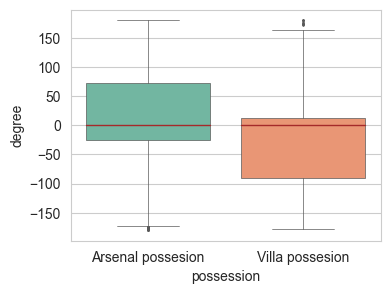

In [16]:
plt.figure(figsize=(4, 3))
ax = sns.boxplot(x='possession', y='degree', data=df, palette = 'Set2', fliersize =0.7, linewidth = 0.5,
           medianprops={'color':'brown', 'linewidth': 1})
ax.set_xticklabels(['Arsenal possesion', 'Villa possesion'])
plt.show()

__*Q: what does this plot tell us?*__ \
(A: there is a noticeable difference in the distribution of play advancement under different possessions.)

__*Q: both boxplots show median = 0, what does this tell us?*__ \
(A: It indicates that degree = 0 lays in the middle of the distribution of degree values in this table. However, it's 
__NOT__ equivalent to "horizontal play advancement lays in the middle of the distribution of all play in this game. \
If we plot the distribution of dx, dy, and degree as below, we see that the data is unbalanced, the frequency of value 0 is way higher than others.)

<Axes: xlabel='degree', ylabel='Count'>

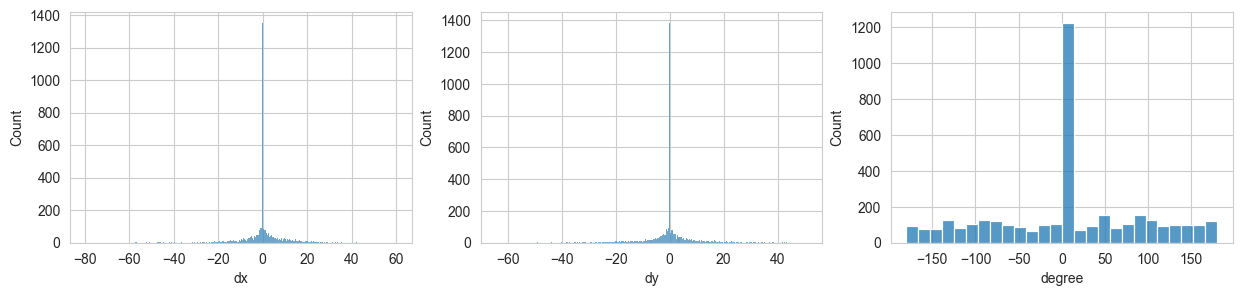

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
sns.histplot(df['dx'], ax=axes[0])

sns.histplot(df['dy'], ax=axes[1])

sns.histplot(df['degree'], ax=axes[2])

Observing the unusual high volumn of 0, we'd like to have a better look at the data.

In [18]:
df.type.value_counts()

type
Pass              1029
Ball Receipt*      999
Carry              936
Pressure           286
Ball Recovery      106
Duel                69
Dribble             49
Interception        48
Block               44
Goal Keeper         39
Clearance           37
Shot                32
Dispossessed        30
Dribbled Past       28
Miscontrol          28
Foul Committed      15
Foul Won            12
Shield               3
50/50                2
Offside              1
Name: count, dtype: int64

The function below helps us to check out the previous and following events for certain type of event.

In [19]:
def check_action(df, action, n):
    '''
    Generate dataframe containing previous and following n rows for certain type of event. 
    
    Arg: df(dataframe)
         action(str)
         n(int)
    Return: dataframe
    '''
    action_idx = df.index[df['type'] == action].tolist()
    display_list = []
    for idx in action_idx:
        display_list.append(idx)
        for offset in range(-n, n+1):
            if (idx + offset) not in display_list:
                display_list.append(idx + offset)
    display_list = [idx for idx in display_list if idx >=0 and idx <len(df)]
    display_list.sort()
    display_df =  df.iloc[display_list]     
    return display_df

In [20]:
display = check_action(df, 'Pressure', 1)
display.head(20)

,minute,second,x,y,team,possession,type,starting,total_seconds,dx,dy,degree,d
10,0,6,53.3,26.8,Arsenal WFC,Arsenal WFC,Carry,No,6,0.0,0.0,0.0,0.0
11,0,7,57.3,25.5,Aston Villa,Arsenal WFC,Pressure,No,7,4.0,-1.3,108.0,4.2
12,0,8,57.2,19.6,Arsenal WFC,Arsenal WFC,Pass,No,8,-0.1,-5.9,-179.0,5.9
14,0,9,62.7,4.6,Arsenal WFC,Arsenal WFC,Carry,No,9,0.0,0.0,0.0,0.0
15,0,9,63.6,8.4,Aston Villa,Arsenal WFC,Pressure,No,9,0.9,3.8,13.0,3.9
16,0,9,63.4,4.6,Arsenal WFC,Arsenal WFC,Pass,No,9,-0.2,-3.8,-177.0,3.8
44,0,36,48.4,3.8,Aston Villa,Aston Villa,Carry,No,36,0.0,0.0,0.0,0.0
45,0,38,49.2,2.7,Arsenal WFC,Aston Villa,Pressure,No,38,0.8,-1.1,144.0,1.4
46,0,38,47.9,3.8,Aston Villa,Aston Villa,Dispossessed,No,38,-1.3,1.1,-50.0,1.7
52,0,40,46.3,16.7,Arsenal WFC,Arsenal WFC,Carry,No,40,0.0,0.0,0.0,0.0


In [21]:
display = check_action(df, 'Block', 1)
display.head(10)

,minute,second,x,y,team,possession,type,starting,total_seconds,dx,dy,degree,d
86,1,27,19.4,25.4,Aston Villa,Aston Villa,Shot,No,87,-1.2,2.5,-26.0,2.8
87,1,27,16.9,27.9,Arsenal WFC,Aston Villa,Block,No,87,-2.5,2.5,-45.0,3.5
88,1,27,1.6,38.6,Arsenal WFC,Aston Villa,Goal Keeper,No,87,-15.3,10.7,-55.0,18.7
190,3,34,74.5,20.3,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,214,12.0,16.2,37.0,20.2
191,3,34,65.0,7.9,Aston Villa,Arsenal WFC,Block,No,214,-9.5,-12.4,-143.0,15.6
192,3,35,63.6,19.5,Aston Villa,Arsenal WFC,Interception,No,215,-1.4,11.6,-7.0,11.7
254,4,53,116.5,37.4,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,293,-1.5,12.3,-7.0,12.4
255,4,53,117.4,28.7,Aston Villa,Arsenal WFC,Block,No,293,0.9,-8.7,174.0,8.7
256,4,54,119.8,37.3,Aston Villa,Arsenal WFC,Goal Keeper,No,294,2.4,8.6,16.0,8.9
332,6,57,95.6,38.9,Arsenal WFC,Arsenal WFC,Shot,No,417,15.3,0.0,90.0,15.3


In [22]:
display = check_action(df, 'Interception', 1)
display.head(10)

,minute,second,x,y,team,possession,type,starting,total_seconds,dx,dy,degree,d
191,3,34,65.0,7.9,Aston Villa,Arsenal WFC,Block,No,214,-9.5,-12.4,-143.0,15.6
192,3,35,63.6,19.5,Aston Villa,Arsenal WFC,Interception,No,215,-1.4,11.6,-7.0,11.7
193,3,35,63.4,19.1,Arsenal WFC,Arsenal WFC,Ball Recovery,No,215,-0.2,-0.4,-153.0,0.4
197,3,37,38.3,19.1,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,217,-16.0,1.9,-83.0,16.1
198,3,37,51.0,18.0,Aston Villa,Arsenal WFC,Interception,No,217,12.7,-1.1,95.0,12.7
199,3,39,51.6,15.7,Arsenal WFC,Arsenal WFC,Pressure,No,219,0.6,-2.3,165.0,2.4
237,4,38,67.8,4.1,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,278,19.3,-45.2,157.0,49.1
238,4,38,68.2,9.1,Aston Villa,Arsenal WFC,Interception,No,278,0.4,5.0,5.0,5.0
239,4,40,48.0,15.2,Arsenal WFC,Arsenal WFC,Pass,No,280,-20.2,6.1,-73.0,21.1
305,6,26,65.1,77.7,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,386,12.8,5.3,68.0,13.9


In [23]:
display = check_action(df, 'Offside', 1)
display.head(10)

,minute,second,x,y,team,possession,type,starting,total_seconds,dx,dy,degree,d
367,7,41,111.6,36.9,Aston Villa,Arsenal WFC,Interception,No,461,0.1,-1.5,176.0,1.5
368,7,44,117.0,13.6,Arsenal WFC,Arsenal WFC,Offside,No,464,5.4,-23.3,167.0,23.9
369,8,15,116.7,21.7,Aston Villa,Aston Villa,Pass,Yes,495,-0.3,8.1,-2.0,8.1


In [24]:
display = check_action(df, 'Ball Receipt*', 1)
display.head(20)

,minute,second,x,y,team,possession,type,starting,total_seconds,dx,dy,degree,d
0,0,0,62.0,42.3,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,0,1.0,2.2,24.0,2.4
1,0,0,62.0,42.3,Arsenal WFC,Arsenal WFC,Carry,No,0,0.0,0.0,0.0,0.0
2,0,0,59.3,40.8,Arsenal WFC,Arsenal WFC,Pass,No,0,-2.7,-1.5,-119.0,3.1
3,0,1,42.0,39.9,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,1,-17.3,-0.9,-93.0,17.3
4,0,1,42.0,39.9,Arsenal WFC,Arsenal WFC,Carry,No,1,0.0,0.0,0.0,0.0
5,0,2,42.9,41.1,Arsenal WFC,Arsenal WFC,Pass,No,2,0.9,1.2,37.0,1.5
6,0,4,40.3,22.7,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,4,-2.6,-18.4,-172.0,18.6
7,0,4,40.3,22.7,Arsenal WFC,Arsenal WFC,Carry,No,4,0.0,0.0,0.0,0.0
8,0,5,40.3,22.7,Arsenal WFC,Arsenal WFC,Pass,No,5,0.0,0.0,0.0,0.0
9,0,6,53.3,26.8,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,6,13.0,4.1,72.0,13.6


In [25]:
rec_idx = df.index[df['type'] == 'Ball Receipt*'].tolist()

In [26]:
after_rec_idx = [idx + 1 for idx in rec_idx]

In [27]:
after_rec = df.iloc[after_rec_idx]
after_rec.head()

,minute,second,x,y,team,possession,type,starting,total_seconds,dx,dy,degree,d
1,0,0,62.0,42.3,Arsenal WFC,Arsenal WFC,Carry,No,0,0.0,0.0,0.0,0.0
4,0,1,42.0,39.9,Arsenal WFC,Arsenal WFC,Carry,No,1,0.0,0.0,0.0,0.0
7,0,4,40.3,22.7,Arsenal WFC,Arsenal WFC,Carry,No,4,0.0,0.0,0.0,0.0
10,0,6,53.3,26.8,Arsenal WFC,Arsenal WFC,Carry,No,6,0.0,0.0,0.0,0.0
14,0,9,62.7,4.6,Arsenal WFC,Arsenal WFC,Carry,No,9,0.0,0.0,0.0,0.0


In [28]:
len(after_rec[after_rec['degree'] != 0])

201

In [29]:
after_rec[after_rec['degree'] != 0]

,minute,second,x,y,team,possession,type,starting,total_seconds,dx,dy,degree,d
39,0,30,80.5,26.0,Aston Villa,Aston Villa,Pass,No,30,1.9,0.4,78.0,1.9
68,0,56,118.8,41.7,Aston Villa,Aston Villa,Goal Keeper,No,56,7.8,6.4,51.0,10.1
93,1,31,46.0,15.1,Aston Villa,Arsenal WFC,Foul Committed,No,91,-10.4,-3.0,-106.0,10.8
191,3,34,65.0,7.9,Aston Villa,Arsenal WFC,Block,No,214,-9.5,-12.4,-143.0,15.6
198,3,37,51.0,18.0,Aston Villa,Arsenal WFC,Interception,No,217,12.7,-1.1,95.0,12.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3697,91,21,111.9,34.2,Aston Villa,Arsenal WFC,Clearance,No,5481,0.2,-4.5,177.0,4.5
3701,91,26,111.1,22.8,Aston Villa,Arsenal WFC,Clearance,No,5486,2.3,4.0,30.0,4.6
3744,92,19,106.2,52.3,Aston Villa,Arsenal WFC,Ball Recovery,No,5539,1.8,-4.9,160.0,5.2
3762,92,36,86.4,28.3,Aston Villa,Aston Villa,Pass,No,5556,-2.3,-1.0,-113.0,2.5


__*Q: After checking out different actions, what do we want to do to make the data better serve the analysis purpose?*__ \
(A: we can remove the rows with d < 1 as it might be recording a player turned her body after receiving the ball which is less relevant. We can also remove rows of Pressure actions, as the event location was often away from the ball.)

In [30]:
df_1 = df[df['d'] >1].reset_index(drop = True)

In [31]:
df_1 =df_1[df_1['type'] != 'Pressure'].reset_index(drop = True)

__*Q: are all values in the 'degree' column relevant?*__ \
(A: we should remove the rows where column 'starting' has value 'Yes' and the rows right below it. Because 1). the location change between a starting action and the event before is not meaningful; 2). as the starting actions are mostly under zero pressure, it's under different circumstances from the regular play, thus the location change after it is not representative for our focus and will create noise.)

In [32]:
df.starting.value_counts()

starting
No     3700
Yes      93
Name: count, dtype: int64

In [33]:
starting_idx = df.index[df['starting'] == 'Yes'].tolist()
df = df.drop(starting_idx + [i + 1 for i in starting_idx])

In [34]:
df_1.describe()

,minute,second,x,y,total_seconds,dx,dy,degree,d
count,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000
mean,45.506932,29.330869,70.121488,39.693623,2759.746765,-0.018438,-0.060767,5.878928,14.104806
std,27.396549,17.074733,28.626072,24.019040,1644.314426,13.490700,13.040860,103.658688,12.368371
min,0.000000,0.000000,0.900000,0.000000,0.000000,-79.500000,-64.300000,-180.000000,1.100000
25%,22.000000,14.000000,48.775000,20.100000,1329.000000,-5.125000,-4.900000,-83.000000,4.700000
50%,45.000000,30.000000,72.100000,38.850000,2715.000000,0.150000,0.050000,6.000000,10.600000
75%,69.000000,44.000000,91.600000,60.650000,4144.250000,6.400000,5.100000,94.250000,19.600000
max,93.000000,59.000000,120.000000,80.000000,5596.000000,60.300000,50.900000,180.000000,81.800000


<Axes: xlabel='degree', ylabel='Count'>

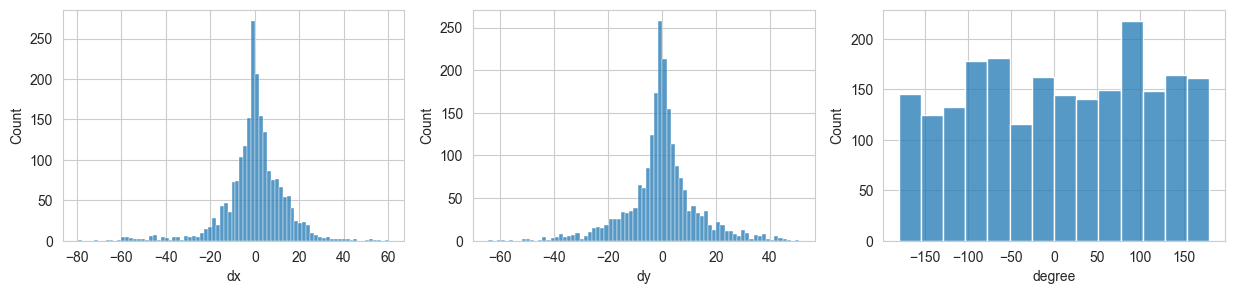

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
sns.histplot(df_1['dx'], ax=axes[0])

sns.histplot(df_1['dy'], ax=axes[1])

sns.histplot(df_1['degree'], ax=axes[2])

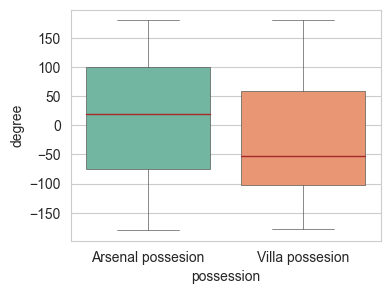

In [36]:
plt.figure(figsize=(4, 3))
ax = sns.boxplot(x='possession', y='degree', data=df_1, palette = 'Set2', fliersize =0.7, linewidth = 0.5,
           medianprops={'color':'brown', 'linewidth': 1})
ax.set_xticklabels(['Arsenal possesion', 'Villa possesion'])
plt.show()

<Axes: xlabel='total_seconds', ylabel='degree'>

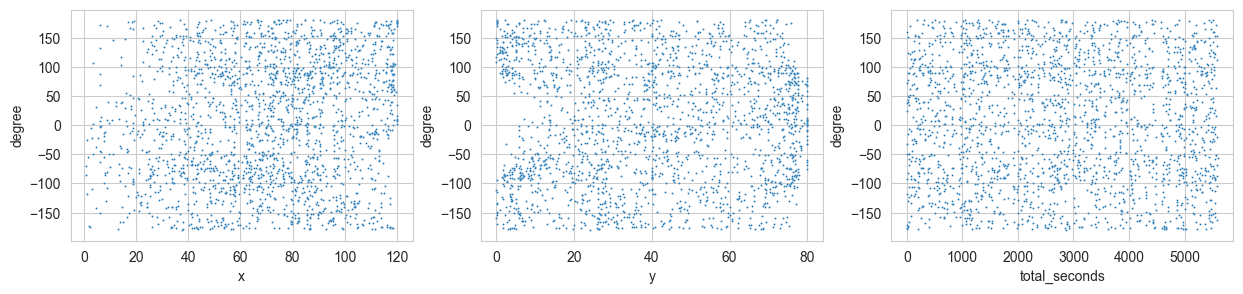

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))

sns.scatterplot(data = df_1, x = 'x', y = 'degree', s = 2, ax=axes[0])

sns.scatterplot(data = df_1, x = 'y', y = 'degree', s = 2, ax=axes[1])

sns.scatterplot(data = df_1, x = 'total_seconds', y = 'degree', s = 2, ax=axes[2])

__*Q: what can we tell from the visualizations?*__

__*Q: are there other ways to visualize this data?*__

__*Q: what will the plots look like if we visualize other games?*__

### 4. Calculate Markov matrix. 

As we see that the trends of play advancement may change when the possesion changes, so we want to seperate the data based on possesion for analysis.

In [38]:
df_2 = df_1.copy()

In [39]:
df_2 = df_2[df_2['possession'] == 'Arsenal WFC'].reset_index(drop = True)

In [40]:
df_2.head()

,minute,second,x,y,team,possession,type,starting,total_seconds,dx,dy,degree,d
0,0,0,62.0,42.3,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,0,1.0,2.2,24.0,2.4
1,0,0,59.3,40.8,Arsenal WFC,Arsenal WFC,Pass,No,0,-2.7,-1.5,-119.0,3.1
2,0,1,42.0,39.9,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,1,-17.3,-0.9,-93.0,17.3
3,0,2,42.9,41.1,Arsenal WFC,Arsenal WFC,Pass,No,2,0.9,1.2,37.0,1.5
4,0,4,40.3,22.7,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,4,-2.6,-18.4,-172.0,18.6


Next step is to identify the play advancement for each row as: 0 (backward), 1 (horizontally), 2 (forward).

In [41]:
df_2['direction'] = df_2.apply(
    lambda row: 2 if row['degree'] > 20 else 0 if row['degree'] <-20 else 1, axis = 1)

In [42]:
df_2['direction'].value_counts()

direction
2    868
0    659
1    212
Name: count, dtype: int64

In [43]:
fw = df_2[df_2['direction'] == 2]['direction']
hr = df_2[df_2['direction'] == 1]['direction']
bw = df_2[df_2['direction'] == 0]['direction']

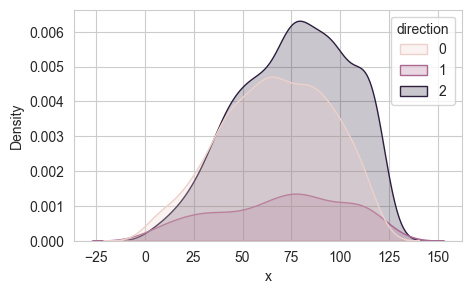

In [44]:
fig, ax = plt.subplots(figsize=(5, 3)) 
sns.kdeplot(data=df_2, x='x', hue="direction", fill=True, ax=ax)
plt.show()

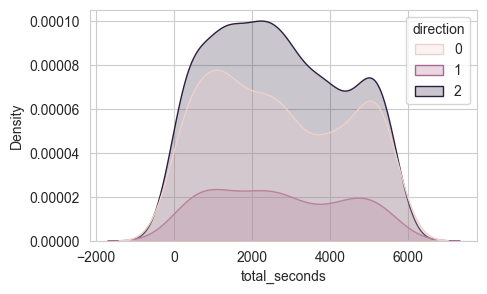

In [45]:
fig, ax = plt.subplots(figsize=(5, 3)) 
sns.kdeplot(data=df_2, x='total_seconds', hue="direction", fill=True, ax=ax)
plt.show()

The code block below calculates the probability matrix for all potential transitions between the three states from this dataset.

In [46]:
n = 3
directions = df_2.direction

P = np.zeros((n, n))
for i in range(len(directions) - 1):
    P[directions[i], directions[i+1]] += 1
P /= P.sum(axis=1)[:,None]
np.round(P, 2)

array([[0.44, 0.14, 0.42],
       [0.32, 0.16, 0.52],
       [0.35, 0.1 , 0.55]])

__*Q: how do we know if those probabilities were constant?*__ \
(A: we can split the dataset into subsets.)

In [47]:
split_idx = np.array_split(directions.index, 8)

In [48]:
def get_matrix(series):
    transition_list = ['B_B', 'B_H', 'B_F', 
                      'H_B', 'H_H', 'H_F',
                      'F_B', 'F_H', 'F_F']
    matrix = {}
    for t in transition_list:
        matrix[t] = []
            
    for i in range(8):
        sub_series = series[split_idx[i]].reset_index(drop = True)
        
        P = np.zeros((n, n))
        for i in range(len(sub_series) - 1):
            P[sub_series[i], sub_series[i+1]] += 1
        P /= P.sum(axis=1)[:,None]
        np.round(P, 2)
        
        for i in range(len(transition_list)):
            key = transition_list[i]
            matrix[key].append(P[i//3][i%3])
    return matrix

In [49]:
matrix = get_matrix(directions)
matrix_df = pd.DataFrame(matrix)

In [50]:
matrix_df

,B_B,B_H,B_F,H_B,H_H,H_F,F_B,F_H,F_F
0,0.452381,0.154762,0.392857,0.333333,0.111111,0.555556,0.358491,0.103774,0.537736
1,0.472527,0.098901,0.428571,0.357143,0.178571,0.464286,0.387755,0.142857,0.469388
2,0.443038,0.101266,0.455696,0.166667,0.166667,0.666667,0.350877,0.105263,0.543860
3,0.413333,0.120000,0.466667,0.307692,0.153846,0.538462,0.313043,0.121739,0.565217
4,0.345679,0.172840,0.481481,0.384615,0.153846,0.461538,0.385321,0.073394,0.541284
5,0.430556,0.138889,0.430556,0.250000,0.166667,0.583333,0.291667,0.083333,0.625000
6,0.407407,0.209877,0.382716,0.371429,0.171429,0.457143,0.360000,0.120000,0.520000
7,0.500000,0.130435,0.369565,0.285714,0.190476,0.523810,0.388350,0.048544,0.563107


In [51]:
matrix_df.describe()

,B_B,B_H,B_F,H_B,H_H,H_F,F_B,F_H,F_F
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,0.433115,0.140871,0.426014,0.307074,0.161577,0.531349,0.354438,0.099863,0.545699
std,0.046599,0.037522,0.041054,0.072485,0.023722,0.072293,0.035712,0.030201,0.043985
min,0.345679,0.098901,0.369565,0.166667,0.111111,0.457143,0.291667,0.048544,0.469388
25%,0.411852,0.115316,0.390322,0.276786,0.153846,0.463599,0.341419,0.080849,0.533302
50%,0.436797,0.134662,0.429563,0.320513,0.166667,0.531136,0.359245,0.104518,0.542572
75%,0.457418,0.159281,0.458439,0.360714,0.173214,0.562500,0.385930,0.120435,0.563634
max,0.500000,0.209877,0.481481,0.384615,0.190476,0.666667,0.388350,0.142857,0.625000


<Axes: >

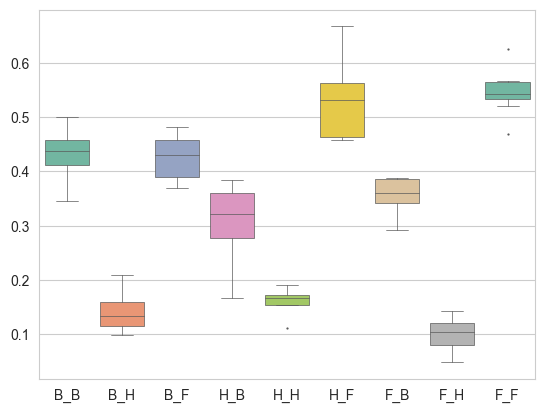

In [52]:
sns.boxplot(data=matrix_df, palette = 'Set2', fliersize =0.7, linewidth = 0.5)

Here we see the range of transition probabilities from eight subsets.

__*Q: is this convincing enough to say the play advancement in a soccer game forms a Markov chain? If not, what can we do next to test the assumption?*__

__*Q: if we treat the play advancement as a Markov chain, what applications we can develop based on that?*__